# Google Revenue Prediction

## Kaggle Challenge Description

## What are we predicting?
We are predicting the **natural log** of the sum of all transactions **per user**.

$$ y_{user} = \sum_{i=1}^n transaction_{user_{i}} $$
$$ target_{user} = ln(y_{user} + 1) $$

## Data Cleansing 

Simply change csv_file to either "test_v2.csv" or "train_v2.csv" to determine which csv to use. Using "test_v2.csv" will make it easier to manage for your system.

In [1]:
%%time
import pandas as pd
import sklearn
from sklearn import model_selection, preprocessing, metrics
import json
import os
import matplotlib
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import numpy as np


CPU times: user 728 ms, sys: 360 ms, total: 1.09 s
Wall time: 1.71 s


In [2]:
%%time
data = 'data'
def load_csv(data, csv_file, nrows):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    print("Loading csv file")
    df = pd.read_csv(os.path.join(os.getcwd(),data,csv_file),
                    converters={column: json.loads for column in JSON_COLUMNS},
                    dtype={'fullVisitorId': 'str'},
                    nrows=nrows)

    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = ["%s.%s" % (column, subcolumn) for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

# Load both the training csv and testing csv
train_df = load_csv(data, "train_v2.csv",2000)
test_df = load_csv(data, "test_v2.csv", 2000)

print("Loading done.")


Loading csv file
Loading csv file
Loading done.
CPU times: user 1.38 s, sys: 135 ms, total: 1.52 s
Wall time: 1.51 s


## Columns and Types
Initially we should dissect the data and learn what columns are found inside the csv file.

In [3]:
train_df.dtypes

channelGrouping                                      object
customDimensions                                     object
date                                                  int64
fullVisitorId                                        object
hits                                                 object
socialEngagementType                                 object
visitId                                               int64
visitNumber                                           int64
visitStartTime                                        int64
device.browser                                       object
device.browserSize                                   object
device.browserVersion                                object
device.deviceCategory                                object
device.flashVersion                                  object
device.isMobile                                        bool
device.language                                      object
device.mobileDeviceBranding             

### Analyzing which Columns are constant

In [4]:
const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1 ]
const_cols

['date',
 'socialEngagementType',
 u'device.browserSize',
 u'device.browserVersion',
 u'device.flashVersion',
 u'device.language',
 u'device.mobileDeviceBranding',
 u'device.mobileDeviceInfo',
 u'device.mobileDeviceMarketingName',
 u'device.mobileDeviceModel',
 u'device.mobileInputSelector',
 u'device.operatingSystemVersion',
 u'device.screenColors',
 u'device.screenResolution',
 u'geoNetwork.cityId',
 u'geoNetwork.latitude',
 u'geoNetwork.longitude',
 u'geoNetwork.networkLocation',
 u'totals.visits',
 u'trafficSource.adwordsClickInfo.criteriaParameters']

We should also remove the constant columns, as they will bring no bearing to the weights on the model.

In [5]:
cols_to_drop = const_cols
#+ ["trafficSource.campaignCode"]
train_df = train_df.drop(cols_to_drop,axis=1)
test_df = test_df.drop(cols_to_drop, axis=1)

# Target Variable Exploration

We need to sum up the transaction revenue on the user level. Then graph a scatter plot of the natural log.


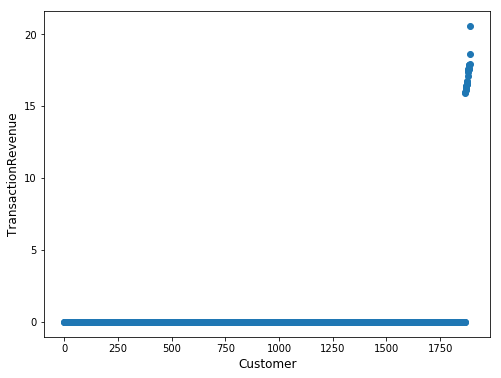

In [6]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('Customer', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

The scatter plot above confirms the 80/20 marketing principle that states 80% of the profits come from 20% of the customers.

From this analysis, this would mean that we have a distinct dataset between customers with TransactionRevenue and customers without TransactionRevenue.


# Developing the model
To discover which is the best model to predict the log revenue of customers. We can do a training analysis based on popular models such as LightGBM, ADABOOST and XGBOOST. All these models can be found in scikit-learn.

First, we need to build the training and testing dataset respectively.

In [7]:
## TODO: Create a template possible to fit with all the models.
## TODO: Divide the training set based on the presence of TransactionRevenue.
## TODO: Write metrics visualization code.
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))

num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)

train_set,test_set = model_selection.train_test_split(train_df, test_size=0.2)

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect


,channelGrouping,customDimensions,fullVisitorId,hits,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
1762,1,"[{'index': '4', 'value': 'Central America'}]",3192129641164034116,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508198647,1.0,1.508199e+09,2,0,False,...,237,1,3,3,2,0,31,0,232,0
318,5,"[{'index': '4', 'value': 'North America'}]",7491354664418615966,"[{'hitNumber': '1', 'time': '0', 'hour': '11',...",1508180358,5.0,1.508180e+09,2,0,False,...,237,1,3,3,2,0,31,5,17,3
1115,3,"[{'index': '4', 'value': 'Central America'}]",8751766235946943282,"[{'hitNumber': '1', 'time': '0', 'hour': '16',...",1508197655,1.0,1.508198e+09,2,0,False,...,237,1,3,3,2,1,3,4,232,15
60,5,"[{'index': '4', 'value': 'North America'}]",5446323589552618007,"[{'hitNumber': '1', 'time': '0', 'hour': '12',...",1508181229,2.0,1.508181e+09,2,0,False,...,237,1,3,3,2,0,31,5,27,9
88,3,"[{'index': '4', 'value': 'APAC'}]",8585866264807101623,"[{'hitNumber': '1', 'time': '0', 'hour': '21',...",1508212902,1.0,1.508213e+09,2,0,False,...,237,1,3,3,2,1,3,4,232,15


## LightGBM

In [8]:
## TODO: Build LightGBM training function.
def train_with_gbm():

IndentationError: expected an indented block (<ipython-input-8-cff2d4ad1304>, line 2)

## ADABOOST 

In [ ]:
## TODO: Build ADABOOST training function.
def train_with_adaboost():

## XGBOOST

In [ ]:
## TODO: Build XGBOOST training function.
def train_with_xgboost():

## Evaluation